# Donkey Car Experiment Cloner

## Notebook Context
This notebook clones all the highlighted experiments conducted in the building up of the Pilot model. Each architecture is reconstructed via logs from neptune and roam. The models are re-trained and rerun each to determine their performance using the new data split


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [ ]:
#Mount Data Folder From Google Drive:
path0 = "./GenTrack5Throttle/"
path1 = "./DefRoad5Throttle/"
path2 = "./WH5Throttle/"
#TEST SETS
path0t = "./GenTrackTestSet1/"

In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/DefRoad5Throttle.zip'
#TEST SETS
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymTestSets_Nov2020/GenTrackTestSet1.zip'

In [ ]:
#Import required packages for this step:
%tensorflow_version 1.x
import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

TensorFlow 1.x selected.


In [ ]:
#Donkey Training and Val data splits
def train_test_split(data_list,label_list, label2_list, shuffle=True, test_size=0.3):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    label2_list = list(label2_list)
    train_data = []
    traina_labels =[]
    traint_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        traint_labels.append(label2_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    valt_labels = label2_list
    del data_list
    del label_list
    del label2_list
    return val_data, train_data, vala_labels, traina_labels, valt_labels, traint_labels

In [ ]:
#Fetch data for training
path = path0

images_0 =[]

train_images = []
val_images = []

images = []
labels = []

label_0 = []

train_labels = []
val_labels = []
#Collect images into respective lists:

for file in os.listdir(path):
    if 'cam' in file:
        images.append(path+file)
    elif 'record' in file:
        labels.append(path+file)

xvall = [] 
xtrainl = [] 
yvalal = []
ytrainal = [] 
yvaltl = []
ytraintl = []
images = natsort.natsorted(images)
labels = natsort.natsorted(labels)
xvall, xtrainl, yvalal, ytrainal, yvaltl, ytraintl = train_test_split(images,labels, labels) 


print("Train labels and images order check:")
print(xtrainl[10])
print(ytrainal[10])

print("Val labels and images order check:")
print(xvall[10])
print(yvalal[10])


Train labels and images order check:
./GenTrack5Throttle/344_cam-image_array_.jpg
./GenTrack5Throttle/record_344.json
Val labels and images order check:
./GenTrack5Throttle/35_cam-image_array_.jpg
./GenTrack5Throttle/record_35.json


No Things to Delete
File Check:


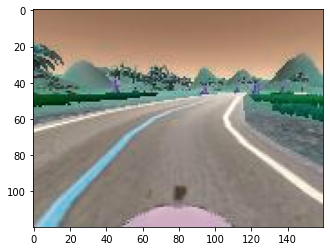

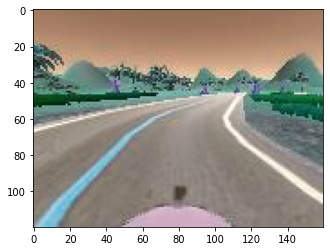

-0.15200207
0.05
-0.1520020594323728
0.05
./GenTrack5Throttle/35_cam-image_array_.jpg
./GenTrack5Throttle/record_35.json


In [ ]:
try:
  del xtrain
  del ytraina
  del ytraint
  del xval
  del yvala
  del yvalt
except:
  print("No Things to Delete")


#Directly reading data into val data split to save RAM

import cv2 as cv


width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple


#Read Images and Labels into arrays:
xtrain = np.zeros((len(xtrainl), 120, 160, 3), dtype=np.float32)
xval = np.zeros((len(xvall), 120, 160, 3), dtype=np.float32)


ytraina = np.zeros(len(ytrainal), dtype=np.float32)
ytraint = np.zeros(len(ytraintl), dtype=np.float32)

yvala = np.zeros(len(yvalal),dtype=np.float32)
yvalt = np.zeros(len(yvaltl),dtype=np.float32)


for i in range(len(xtrainl)):
    xtrain[i,:,:,:] = cv.imread(xtrainl[i])
    xtrain[i] = xtrain[i]/255 #Normalise between 0 and 1 - better for tf
    with open(ytrainal[i]) as file:
        jdata = json.load(file)
        ytraina[i] = jdata['user/angle']   #angle data
    with open(ytraintl[i]) as file:
        jdata = json.load(file)    
        ytraint[i] = jdata['user/throttle'] #throttle data

for i in range(len(xvall)):
    xval[i,:,:,:] = cv.imread(xvall[i])
    xval[i] = xval[i]/255 #Normalise between 0 and 1 - better for tf
    with open(yvalal[i]) as file:
        jdata = json.load(file)
        yvala[i] = jdata['user/angle']   #angle data
    with open(yvaltl[i]) as file:
        jdata = json.load(file)
        yvalt[i] = jdata['user/throttle'] #throttle data

print("File Check:")
image = cv.imread(xvall[250])
plt.imshow(image)
plt.show()
plt.imshow(xval[250])
plt.show()
print(yvala[10])
print(yvalt[10])
with open(yvalal[10]) as file:
    tdata = json.load(file)
    print(tdata['user/angle'])
with open(yvaltl[10]) as file:
    tdata = json.load(file)
    print(tdata['user/throttle'])
    
print(xvall[10])
print(yvalal[10])

### Step 2: Set up Network and Experiment
Regression CNN as set up in Phase 1 of experimentation and design.

This is also where the Neptune experiment setup begins. This will follow mostly the same style as found in the Donkey Toy Experiment notebook. The Neptune experiment tracker for the littlefoot project can be found at https://ui.neptune.ai/charag/Littlefoot/experiments?viewId=standard-view. Currently, we are tracking the validation loss and accuracy of the default setup, and are comparing variations in layer amounts, layer sizes, kernel sizes, and other parameters that will be listed. 

This experiment set will be tagged DefaultCNN and DiverseCanny in Neptune.

In [ ]:
import os
os.environ['NEPTUNE_API_TOKEN'] = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiOTgyNzBkM2EtMzZhNC00NDkwLWJiNmEtNDJiYzQ0ZDRjZWNkIn0='

In [ ]:

#Neptune experiment initialization:
try:
   import neptune
except:
  !pip install neptune-client
  import neptune
#Import neptune and initialise tracking of an experiment

neptune.init(
    api_token=None,
    project_qualified_name="charag/Littlefoot"
) #API Token is set to environment variable and the project name littlefoot is selected


#Enable logging in a neptune experiment - define keras callbacks and create a neptune logger class

from tensorflow.keras.callbacks import Callback

class NeptuneLogger(Callback):

    def on_batch_end(self, batch, logs={}): #Log metrics after every batch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'batch_{log_name}', log_value)

    def on_epoch_end(self, epoch, logs={}): #log metrics after every epoch
        for log_name, log_value in logs.items():
            neptune.log_metric(f'epoch_{log_name}', log_value)


#Experiment Parameters:

OPTIMIZER = 'adam' #stochastic gradient descent
LOSS = 'mse' #absolute error from the value desired
#LOSS = 'mae'
EPOCH = 150
BATCH = 132
KERNEL1 = 5
KERNEL2 = 3
STRIDE = 2
CONVLAYERS = 6
DENSELAYERS = 4
POOLLAYERS = 1
PRUNING = "dropout"
FeatureEng = "none"
Dataset = "GenTrack"

In [ ]:
#Start Experiment:
#, Canny, 40-120 thresholds, Thresholding at 230 each channel, Blur with 5x5 Kernel
neptune.create_experiment(name='Experiment Clone (Lit-136)',
                          params={'epochs': EPOCH,
                                  'batch_size': BATCH,
                                  'Optimization' : OPTIMIZER,
                                  'LOSS': LOSS,
                                  'Dataset' : Dataset,
                                  'FeatureEngineering': FeatureEng,
                                  'Convolutional Layers': CONVLAYERS,
                                  'Dense Layers': DENSELAYERS,
                                  'Pooling Layers': POOLLAYERS},         
                          tags=['Build',FeatureEng, Dataset],
                          description="Experiment Clone for Lit-136 Architecture"
                          )


https://ui.neptune.ai/charag/Littlefoot/e/LIT-266


Experiment(LIT-266)

In [ ]:
# Imports: Tensorflow 1.14.0 is used
%tensorflow_version 1.x

import os
import numpy as np

from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Convolution2D, Convolution1D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Cropping2D, Lambda


In [ ]:
#Model Structure Setup: (Lit-59 Clone)
drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#Lit-73 Clone

drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
#Lit-77 Clone:

drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

In [ ]:
#Lit-100 Clone:

drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

In [ ]:
#Lit-136 Duplicate:


drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(500, activation='relu')(x) 
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

In [ ]:
#Lit-138 Duplicate:

drop = 0.10
num_outputs = 2

img_in = Input(shape=(120,160,3), name='img_in')
x = img_in
x = Convolution2D(12, (3,3), strides=(2,2), activation='relu')(x)
x = Convolution2D(24, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(32, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = MaxPooling2D(3,1,padding='valid')(x)
x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)
x = Dropout(drop)(x)
x = Convolution2D(128, (3,3), strides=(2,2), activation='relu')(x)
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dense(500, activation='relu')(x) 
x = Dense(250, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)

outputs = []
    
for i in range(num_outputs):
    outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
model = Model(inputs=[img_in], outputs=outputs)

In [ ]:
#Compile Model 
model.compile(optimizer=OPTIMIZER,
    loss=LOSS)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 59, 79, 12)   336         img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 29, 39, 24)   2616        conv2d_18[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 29, 39, 24)   0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [ ]:
#Name Model
modelname = '138Clone_LIT-266.h5'

In [ ]:
#Fit Model to Data
EarlyStop = keras.callbacks.EarlyStopping(monitor='val_n_outputs0_loss', patience=50)
save_best = keras.callbacks.ModelCheckpoint(modelname, monitor='val_n_outputs0_loss', verbose=1, save_best_only=True, mode='min')
#model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH, validation_data=(x_val, y_val),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)


model.fit(xtrain, [ytraina, ytraint], epochs=EPOCH, batch_size=BATCH, validation_data=(xval, [yvala, yvalt]),callbacks=[NeptuneLogger(), EarlyStop, save_best], shuffle=True, verbose=1)
neptune.log_artifact(modelname)
neptune.stop()

Train on 11197 samples, validate on 4798 samples
Epoch 1/150
10956/11197 [============================>.] - ETA: 0s - loss: 0.0298 - n_outputs0_loss: 0.0293 - n_outputs1_loss: 4.7282e-04
Epoch 00001: val_n_outputs0_loss improved from inf to 0.01803, saving model to 138Clone_LIT-266.h5
11197/11197 [==============================] - 12s 1ms/sample - loss: 0.0295 - n_outputs0_loss: 0.0291 - n_outputs1_loss: 4.6210e-04 - val_loss: 0.0185 - val_n_outputs0_loss: 0.0180 - val_n_outputs1_loss: 3.8642e-04
Epoch 2/150
10956/11197 [============================>.] - ETA: 0s - loss: 0.0142 - n_outputs0_loss: 0.0139 - n_outputs1_loss: 2.7123e-04
Epoch 00002: val_n_outputs0_loss improved from 0.01803 to 0.01263, saving model to 138Clone_LIT-266.h5
11197/11197 [==============================] - 5s 423us/sample - loss: 0.0142 - n_outputs0_loss: 0.0139 - n_outputs1_loss: 2.6515e-04 - val_loss: 0.0129 - val_n_outputs0_loss: 0.0126 - val_n_outputs1_loss: 3.8105e-04
Epoch 3/150
10956/11197 [===============

## STEP 3: Validate Your Model
After the experiment has completed, select a random image/label pair with which to run a prediction, or even a set of these predictions, to have a tangible vision of how the model performs.

In [ ]:
test_data = []
test_labels = []

patht = path0

for file in os.listdir(patht):
  if "cam" in file:
    test_data.append(file)
  elif "record" in file:
    test_labels.append(file)


Testing on Validation Dataset -  ./GenTrack5Throttle/


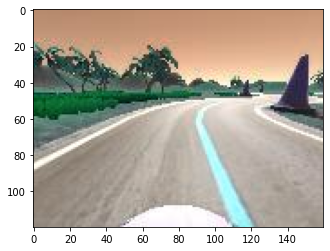

In [ ]:
#Load Test Datasets
if (patht != path):
  try:
    del xval
    del yvala
    del yvalt
  except:
    print("No Things to Delete")
else:
  print("Testing on Validation Dataset - ", path)

try:
  del xtrain
  del ytraina
  del ytraint
  
except:
  try:
    del x_test
    del y_testa
    del y_testt
  except:
    print("No Things to Delete")

#Import Image from Pillow
from PIL import Image
import cv2 as cv
test_data = natsort.natsorted(test_data)
test_labels = natsort.natsorted(test_labels)


#Create Images array:

width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple

#Initialise images array:
if patht == path:
  x_test = xval
  y_testa = yvala
  y_testt = yvalt
else:
  x_test = np.zeros((len(test_labels), width, height, color), dtype = np.float32)

  print(x_test.shape)
  for i in range(len(test_data)):
      filename = test_data[i]
      x_test[i,:,:,:] = cv2.imread(patht+filename)
      x_test[i] = x_test[i]/255

#read angle labels into y_angle array
  json_data = {}
  y_testa = np.zeros(len(test_labels), dtype=np.float32) #setup label array 
  y_testt = np.zeros(len(test_labels), dtype=np.float32) #setup label array 

  for i in range(len(test_labels)):
      filename = test_labels[i]
      with open(patht+filename) as fp:
          json_data = json.load(fp)
          orient = json_data['user/angle']
          y_testa[i] = orient
          vroom = json_data['user/throttle']
          y_testt[i] = vroom

plt.imshow(x_test[100])
plt.show()

Evaluation on  ./GenTrack5Throttle/


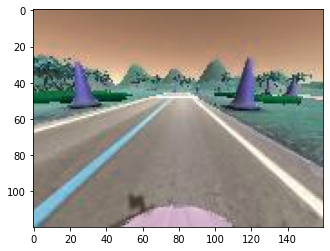

Label:
0.010460479
4798/4798 [==============================] - 1s 274us/sample - loss: 0.0017 - n_outputs0_loss: 0.0016 - n_outputs1_loss: 1.7801e-04
[[ 0.11031881]
 [ 0.18898876]
 [ 0.04818437]
 ...
 [-0.00453604]
 [-0.00863848]
 [-0.00863848]]
(2, 4798)
result:
0.033818193
0.04941033
0.021231903205033688
Prediction Accuracy
0.9787680967949663
Percentage Deviation
0.021231903205033653
Mean Absolute Error
0.021231905
Root Mean Squared Error
0.03953436375358804
R2 Score
0.9615117279157994


In [ ]:
modelname = '138Clone_LIT-266.h5'
ModelBest = keras.models.load_model(modelname)
BATCH=132
num = randrange(len(x_test))
print("Evaluation on ", path0)
#Select Random Image and Label to show as examples
plt.imshow(x_test[num])
plt.show()

pred_im = x_test[num]
pred_label = y_testa[num]

print("Label:")
print(pred_label)

#Model prediction
diff = np.zeros(len(y_testa))
perc = np.zeros(len(y_testa))


#label_out = model.predict(x_val, batch_size=BATCH,verbose=1)
label_out = ModelBest.predict(x_test, batch_size=BATCH,verbose=1)

ModelBest.evaluate(x_test, [y_testa, y_testt], batch_size=BATCH, verbose=1)

print(label_out[1])
label_out = np.asarray(label_out)
label_out=np.squeeze(label_out)
print(label_out.shape)
for i in range(0, len(y_testa)):
  diff[i] = abs(y_testa[i] - label_out[0,i])
  perc[i] = (np.max(y_testa)-diff[i])/np.max(y_testa)
#model.save('LIT-16.h5')
print("result:")
print(label_out[0,num])
print(label_out[1,num])
print(np.sum(diff)/len(diff))
print("Prediction Accuracy")
print(np.sum(perc)/len(perc))
print("Percentage Deviation")
print(1-np.sum(perc)/len(perc))


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from math import sqrt

rmse = sqrt(mean_squared_error(y_testa, label_out[0]))
mae = mean_absolute_error(y_testa, label_out[0])
r2 = r2_score(y_testa, label_out[0])
print("Mean Absolute Error")
print(mae)
print("Root Mean Squared Error")
print(rmse)
print("R2 Score")
print(r2)
